In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Loading the transferdata

In [4]:
df = pd.read_csv('transfer_data.csv')

### Inflation adjusted transfer fees (in €)


Text(0.5, 1.0, 'Inflation adjusted transfer fees \nBig Five Leagues')

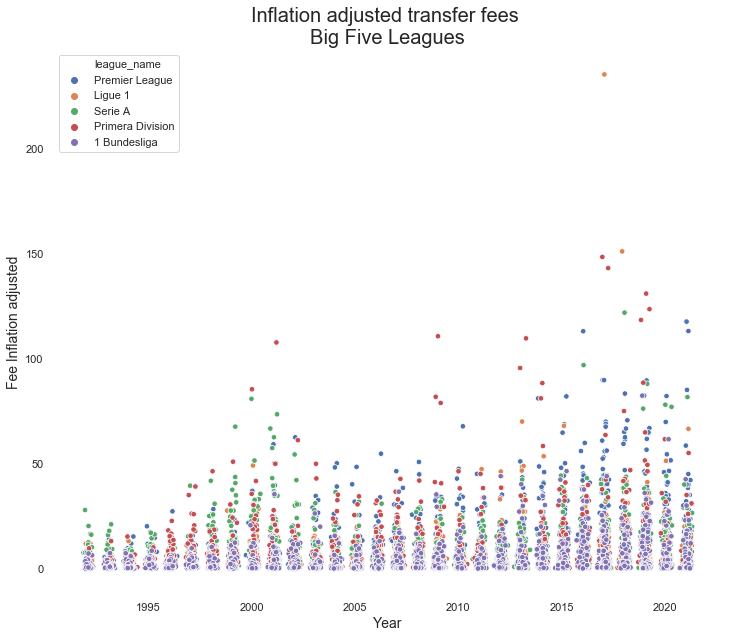

In [5]:
def jitter(values, j):
    return values + np.random.normal(j, 0.1,values.shape)

sns.set(rc={'figure.figsize':(12,10)})
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

plot1 = sns.scatterplot(
    x = jitter(df.year, 0.1),
    y = df.fee_infladj,
    hue =df.league_name, s=30, alpha=1 )
plot1.set_xlabel("Year", fontsize = 14)
plot1.set_ylabel("Fee Inflation adjusted", fontsize = 14)
plot1.set_title("Inflation adjusted transfer fees \nBig Five Leagues", fontsize=20)

### Median Growth For Each League


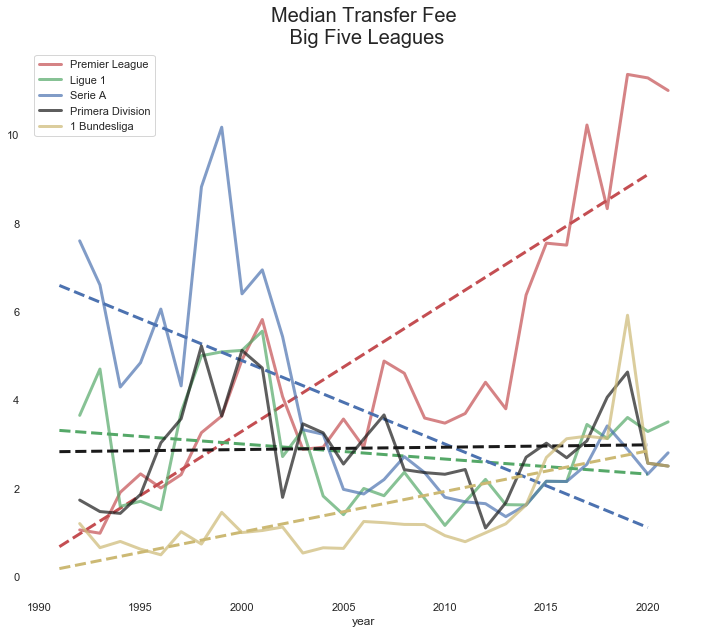

In [8]:
# Median Growth For Each League
median_growth = df.groupby(['league_name', 'year'])['fee_infladj'].median()

from sklearn.linear_model import LinearRegression

league_growth = {}
X = np.arange(1991,2021).reshape(-1,1)

colors = ['r','g','b','k','y']

verbose = False

for i,league in enumerate(df["league_name"].unique()):
    
    # regression of median transfer value vs year
    y = median_growth[league].to_numpy()
    league_growth[league] = LinearRegression().fit(X,y)
    
    # Plotting the median trends
    median_growth[league].plot(label=league,color=colors[i], linewidth=3, alpha=0.7)
    plt.plot(X, league_growth[league].predict(X), linestyle='--',linewidth = 3, 
             #label=league,
             color=colors[i])
    plt.legend()
    
    plt.title("Median Transfer Fee\n Big Five Leagues", fontsize = 20)
    
    if verbose == True:
        # Printing R2 score and regression coefficients for each league
        print("League: " +league + "")
        print("Score= {} ".format(league_growth[league].score(X,y)))
        print("Regression equation : \nMedian = {}x+{} \n".format(league_growth[league].coef_[0],
                                                                league_growth[league].intercept_))

### Median transfer vs Amount of Transfers

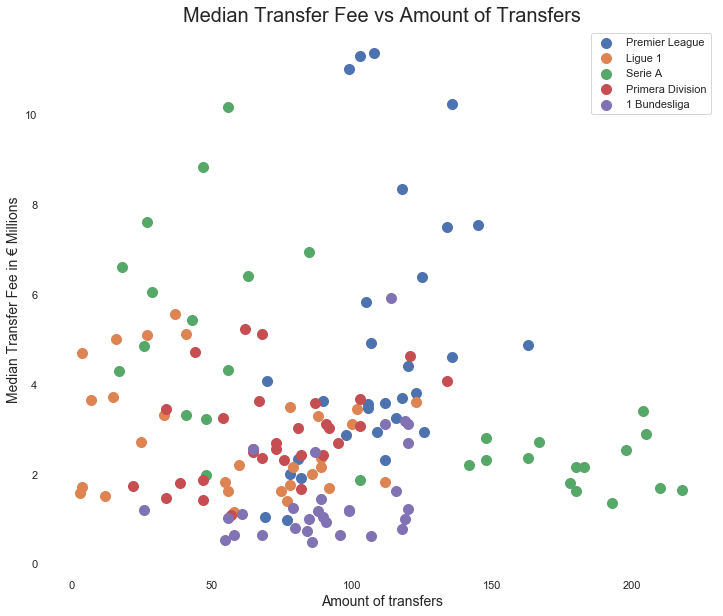

In [9]:
n_transfers = df.groupby(['league_name', 'year'])['fee_infladj'].count()
for league in df["league_name"].unique():
    plt.scatter(n_transfers[league],
                median_growth[league],
                label=league,
                s= 100)
    plt.xlabel("Amount of transfers", fontsize = 14)
    plt.ylabel("Median Transfer Fee in € Millions", fontsize = 14)
    plt.title("Median Transfer Fee vs Amount of Transfers", fontsize=20)
    plt.legend()

### Distribution plot of Transfer Fee for the Big Five Leagues

Text(0, 0.5, '% of all transfers\n across Big Five Leagues')

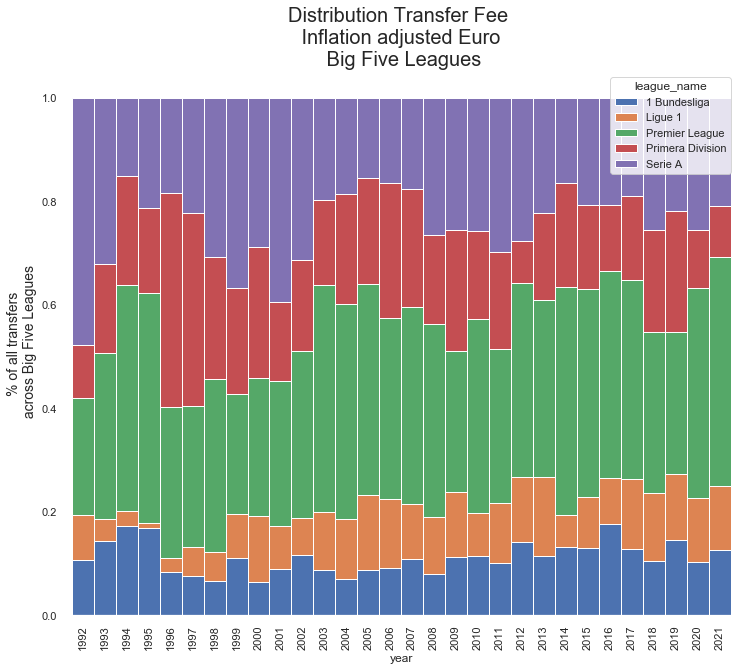

In [10]:
# Cross tab for transfer fees
cross_tab_prop = pd.crosstab(index=df["year"],
                            columns = df["league_name"],
                             values = df["fee_infladj"], aggfunc = 'sum', normalize='index')
cross_tab_prop.plot(kind="bar", stacked=True, width=1)
plt.title("Distribution Transfer Fee \n Inflation adjusted Euro \n Big Five Leagues", fontsize=20)
plt.ylabel("% of all transfers\n across Big Five Leagues", fontsize=14)

### Median fee for transfer as a function of Age

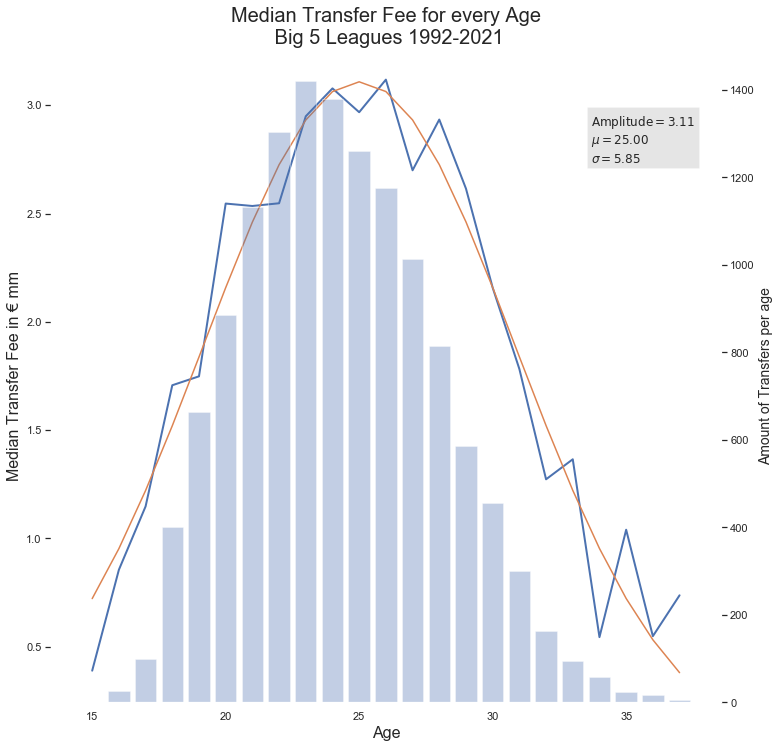

In [22]:
from scipy.optimize import curve_fit
age_fee = df.groupby(["age"])["fee_infladj"].median() 
n_age_fee = df.groupby(["age"])["fee_infladj"].count()


ages = np.sort(df["age"].dropna().unique())
med_fee = age_fee.to_numpy()
n_age_fee = n_age_fee.to_numpy()



def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def Gauss_finder(x,y):
    # Need "from scipy.optimize import curve_fit"
    mean = np.mean(x)
    sigma = np.std(ages)
    parameters, covariance = curve_fit(Gauss, x, y, p0=[3, mean, sigma])
    fit_A, fit_B, fit_C = parameters
    y_gauss = Gauss(x, fit_A, fit_B, fit_C)
    return y_gauss, fit_A, fit_B, fit_C

# Fitting normal distribution
med_fee_pred, fit_A, fit_B, fit_C = Gauss_finder(ages, med_fee)


fig, ax1 = plt.subplots(figsize=(12,12))
ax2 = ax1.twinx()


plt.grid(b=None)


# Plotting distribution
ax1.plot(ages, med_fee, linewidth=2)
ax1.plot(ages, med_fee_pred)
ax1.set_title("Median Transfer Fee for every Age\n Big 5 Leagues 1992-2021", fontsize=20)
ax1.set_xlabel("Age", fontsize=16)
ax1.set_ylabel("Median Transfer Fee in € mm", fontsize=16)


# Plottin barplot
ax2.bar(ages, n_age_fee, alpha=0.34)
ax2.set_ylabel("Amount of Transfers per age", fontsize=14)


textstr = '\n'.join((
    r'$\mathrm{Amplitude}=%.2f$' % (fit_A),
    r'$\mu=%.2f$' % (fit_B, ),
    r'$\sigma=%.2f$' % (fit_C, )))

fig.text(0.75, 0.75, textstr, bbox=dict(facecolor='gray', alpha=0.2))

plt.savefig(fname = "agedecay.png", dpi=300)


### Average Age of Players over the years

Text(0, 0.5, 'Average Age')

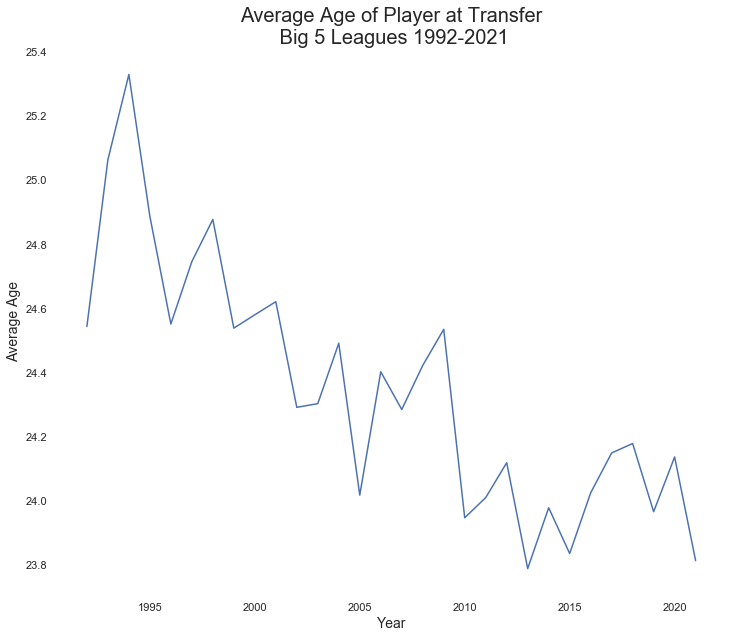

In [23]:
plt.plot(df.groupby(["year"])["age"].mean())
plt.title("Average Age of Player at Transfer\n Big 5 Leagues 1992-2021", fontsize=20)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Average Age", fontsize=14)

### Average time between Transfers

In [25]:
# Finding duplicates
duplicates = df[df.duplicated(subset="player_name")]
dupe_players = duplicates["player_name"].unique()
m_df = df[df["player_name"].isin(dupe_players)]

# Adding "summer" to the years
m_df.loc[m_df["Month"]==8, "year"] +=0.5
m_df.head(3)

# Grouping every player for access to transfer history
player_df = m_df.groupby("player_name")


C:\Users\Jesterbtw\Anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [27]:
dupe_fee = np.array([])
dupe_time = np.array([])

for dupe in dupe_players:
    temp = player_df.get_group(dupe)
    
    if np.any(temp["year"].diff()[1:].to_numpy() >14):
        print(dupe)
    dupe_time = np.append(dupe_time, np.abs(temp["year"].diff()[1:]).to_numpy()) # time between transfers
    dupe_fee = np.append(dupe_fee, temp["fee_infladj"][1:].to_numpy()) # transfer_fee after the transfer
    
# Many of the player_names are used for multiple players and is therefore non-unique. 
# This flaw is hopefully overshadowed by the "unique" player_names.
# player_df.get_group("Pape Sarr")

Cafú
Juanfran
Lionel Scaloni
Jorginho
Paolo Cannavaro
Pedro
Juanmi
Juan Carlos
Luciano
Matt Clarke
Pape Sarr


Text(0, 0.5, 'Median Transfer Fee (€ MM)')

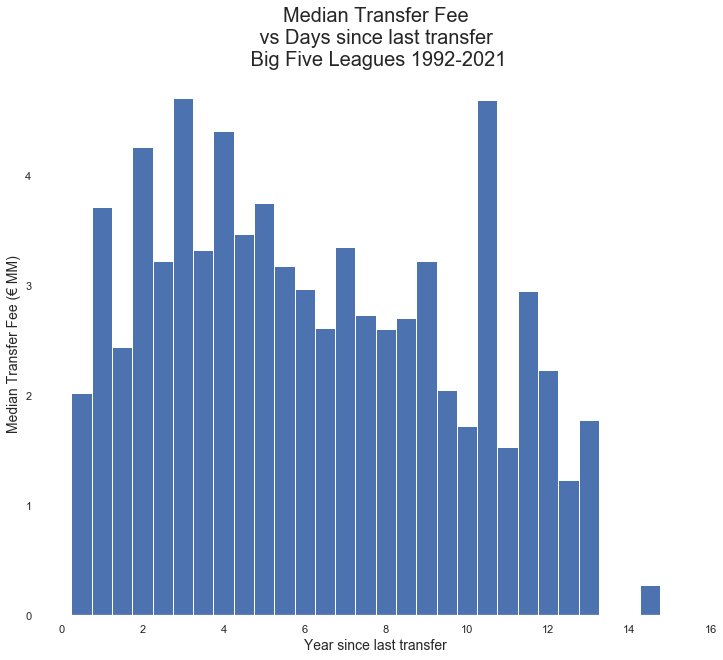

In [28]:
dupe_data = pd.DataFrame(np.concatenate([dupe_time.reshape(-1,1),
                                         dupe_fee.reshape(-1,1)],
                                        axis=1),
                         columns=['transfer_dt', 'transfer_fee'])

dupe_hist = dupe_data.groupby('transfer_dt')['transfer_fee'].median()[:15]

plt.bar(x = dupe_hist.index[1:],
        height = dupe_hist.to_numpy()[1:],#/np.sum(dupe_hist.to_numpy()[1:]),
        width=0.5
       )

plt.title("Median Transfer Fee\n vs Days since last transfer \n Big Five Leagues 1992-2021", fontsize=20)
plt.xlabel("Year since last transfer", fontsize=14)
plt.ylabel("Median Transfer Fee (€ MM)", fontsize=14)

# Stats data Ad Hoc Analysis

In [64]:
df = pd.read_csv("stats_data.csv", dtype={"age" : "int64"})
pd.options.display.max_columns = None


In [65]:
years = df["year"].unique()

In [66]:
for col in df.columns:
    print(col)
    print(df[col].dtype)

season
object
player
object
nationality
object
position
object
squad
object
age
int64
birth_year
float64
minutes_90s
float64
goals_against_gk
float64
pens_allowed
float64
free_kick_goals_against_gk
float64
corner_kick_goals_against_gk
float64
own_goals_against_gk
float64
psxg_gk
float64
psnpxg_per_shot_on_target_against
float64
psxg_net_gk
float64
psxg_net_per90_gk
float64
passes_completed_launched_gk
float64
passes_launched_gk
float64
passes_pct_launched_gk
float64
passes_gk
float64
passes_throws_gk
float64
pct_passes_launched_gk
float64
passes_length_avg_gk
float64
goal_kicks
float64
pct_goal_kicks_launched
float64
goal_kick_length_avg
float64
crosses_gk
float64
crosses_stopped_gk
float64
crosses_stopped_pct_gk
float64
def_actions_outside_pen_area_gk
float64
def_actions_outside_pen_area_per90_gk
float64
avg_distance_def_actions_gk
float64
matches
object
season.1
object
goals
float64
shots_total
float64
shots_on_target
float64
shots_on_target_pct
float64
shots_total_per90
float64
shot

In [67]:
df.head()

,season,player,nationality,position,squad,age,birth_year,minutes_90s,goals_against_gk,pens_allowed,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,matches,season.1,goals,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,average_shot_distance,shots_free_kicks,pens_made,pens_att,xg,npxg,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,assists,xa,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_defense,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_defense,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,tackles_interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,pass_targets,passes_received,passes_received_pct,progressive_passes_received,league,year
0,2019-2020,Aaron Connolly,ie IRL,FW,Brighton,19,2000.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matches,2019-2020,3.0,38.0,13.0,34.2,2.72,0.93,0.08,0.23,15.9,0.0,0.0,0.0,3.2,3.2,0.08,-0.2,-0.2,126.0,163.0,77.3,1739.0,242.0,76.0,92.0,82.6,31.0,39.0,79.5,7.0,11.0,63.6,1.0,0.3,0.7,6.0,6.0,2.0,0.0,10.0,148.0,15.0,0.0,1.0,50.0,0.0,7.0,0.0,0.0,0.0,0.0,90.0,52.0,21.0,27.0,107.0,13.0,1.0,6.0,0.0,1.0,4.0,10.0,25.0,1.79,7.0,0.0,3.0,3.0,9.0,3.0,5.0,0.36,1.0,0.0,1.0,1.0,2.0,0.0,12.0,8.0,1.0,5.0,6.0,3.0,12.0,25.0,9.0,234.0,69.0,29.5,14.0,94.0,126.0,8.0,1.0,0.0,7.0,5.0,17.0,1.0,0.0,349.0,2.0,21.0,149.0,199.0,61.0,334.0,6.0,16.0,37.5,6.0,1.0,228.0,1203.0,657.0,39.0,9.0,12.0,42.0,34.0,535.0,235.0,43.9,99.0,Premier League,2020
1,2020-2021,Aaron Connolly,ie IRL,FW,Brighton,20,2000.0,8.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Matches,2020-2021,2.0,23.0,8.0,34.8,2.62,0.91,0.09,0.25,13.7,0.0,0.0,0.0,3.5,3.5,0.15,-1.5,-1.5,79.0,101.0,78.2,1147.0,165.0,45.0,56.0,80.4,26.0,30.0,86.7,4.0,5.0,80.0,1.0,0.2,0.8,5.0,2.0,1.0,0.0,3.0,91.0,10.0,0.0,0.0,22.0,1.0,2.0,0.0,0.0,0.0,0.0,64.0,26.0,11.0,11.0,74.0,5.0,0.0,3.0,0.0,0.0,2.0,4.0,12.0,1.37,7.0,0.0,3.0,0.0,2.0,0.0,1.0,0.11,1.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,2.0,4.0,1.0,1.0,5.0,20.0,4.0,124.0,40.0,32.3,7.0,58.0,59.0,9.0,1.0,0.0,8.0,0.0,7.0,1.0,0.0,201.0,1.0,14.0,84.0,116.0,38.0,191.0,8.0,10.0,80.0,8.0,0.0,124.0,655.0,387.0,17.

In [68]:
drop_col = ['nationality', 'squad', 'matches', 'season.1']
df.drop(columns=drop_col, inplace=True)
df.head()

,season,player,position,age,birth_year,minutes_90s,goals_against_gk,pens_allowed,free_kick_goals_against_gk,corner_kick_goals_against_gk,own_goals_against_gk,psxg_gk,psnpxg_per_shot_on_target_against,psxg_net_gk,psxg_net_per90_gk,passes_completed_launched_gk,passes_launched_gk,passes_pct_launched_gk,passes_gk,passes_throws_gk,pct_passes_launched_gk,passes_length_avg_gk,goal_kicks,pct_goal_kicks_launched,goal_kick_length_avg,crosses_gk,crosses_stopped_gk,crosses_stopped_pct_gk,def_actions_outside_pen_area_gk,def_actions_outside_pen_area_per90_gk,avg_distance_def_actions_gk,goals,shots_total,shots_on_target,shots_on_target_pct,shots_total_per90,shots_on_target_per90,goals_per_shot,goals_per_shot_on_target,average_shot_distance,shots_free_kicks,pens_made,pens_att,xg,npxg,npxg_per_shot,xg_net,npxg_net,passes_completed,passes,passes_pct,passes_total_distance,passes_progressive_distance,passes_completed_short,passes_short,passes_pct_short,passes_completed_medium,passes_medium,passes_pct_medium,passes_completed_long,passes_long,passes_pct_long,assists,xa,xa_net,assisted_shots,passes_into_final_third,passes_into_penalty_area,crosses_into_penalty_area,progressive_passes,passes_live,passes_dead,passes_free_kicks,through_balls,passes_pressure,passes_switches,crosses,corner_kicks,corner_kicks_in,corner_kicks_out,corner_kicks_straight,passes_ground,passes_low,passes_high,passes_left_foot,passes_right_foot,passes_head,throw_ins,passes_other_body,passes_offsides,passes_oob,passes_intercepted,passes_blocked,sca,sca_per90,sca_passes_live,sca_passes_dead,sca_dribbles,sca_shots,sca_fouled,sca_defense,gca,gca_per90,gca_passes_live,gca_passes_dead,gca_dribbles,gca_shots,gca_fouled,gca_defense,tackles,tackles_won,tackles_def_3rd,tackles_mid_3rd,tackles_att_3rd,dribble_tackles,dribbles_vs,dribble_tackles_pct,dribbled_past,pressures,pressure_regains,pressure_regain_pct,pressures_def_3rd,pressures_mid_3rd,pressures_att_3rd,blocks,blocked_shots,blocked_shots_saves,blocked_passes,interceptions,tackles_interceptions,clearances,errors,touches,touches_def_pen_area,touches_def_3rd,touches_mid_3rd,touches_att_3rd,touches_att_pen_area,touches_live_ball,dribbles_completed,dribbles,dribbles_completed_pct,players_dribbled_past,nutmegs,carries,carry_distance,carry_progressive_distance,progressive_carries,carries_into_final_third,carries_into_penalty_area,miscontrols,dispossessed,pass_targets,passes_received,passes_received_pct,progressive_passes_received,league,year
0,2019-2020,Aaron Connolly,FW,19,2000.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,38.0,13.0,34.2,2.72,0.93,0.08,0.23,15.9,0.0,0.0,0.0,3.2,3.2,0.08,-0.2,-0.2,126.0,163.0,77.3,1739.0,242.0,76.0,92.0,82.6,31.0,39.0,79.5,7.0,11.0,63.6,1.0,0.3,0.7,6.0,6.0,2.0,0.0,10.0,148.0,15.0,0.0,1.0,50.0,0.0,7.0,0.0,0.0,0.0,0.0,90.0,52.0,21.0,27.0,107.0,13.0,1.0,6.0,0.0,1.0,4.0,10.0,25.0,1.79,7.0,0.0,3.0,3.0,9.0,3.0,5.0,0.36,1.0,0.0,1.0,1.0,2.0,0.0,12.0,8.0,1.0,5.0,6.0,3.0,12.0,25.0,9.0,234.0,69.0,29.5,14.0,94.0,126.0,8.0,1.0,0.0,7.0,5.0,17.0,1.0,0.0,349.0,2.0,21.0,149.0,199.0,61.0,334.0,6.0,16.0,37.5,6.0,1.0,228.0,1203.0,657.0,39.0,9.0,12.0,42.0,34.0,535.0,235.0,43.9,99.0,Premier League,2020
1,2020-2021,Aaron Connolly,FW,20,2000.0,8.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,23.0,8.0,34.8,2.62,0.91,0.09,0.25,13.7,0.0,0.0,0.0,3.5,3.5,0.15,-1.5,-1.5,79.0,101.0,78.2,1147.0,165.0,45.0,56.0,80.4,26.0,30.0,86.7,4.0,5.0,80.0,1.0,0.2,0.8,5.0,2.0,1.0,0.0,3.0,91.0,10.0,0.0,0.0,22.0,1.0,2.0,0.0,0.0,0.0,0.0,64.0,26.0,11.0,11.0,74.0,5.0,0.0,3.0,0.0,0.0,2.0,4.0,12.0,1.37,7.0,0.0,3.0,0.0,2.0,0.0,1.0,0.11,1.0,0.0,0.0,0.0,0.0,0.0,7.0,5.0,2.0,4.0,1.0,1.0,5.0,20.0,4.0,124.0,40.0,32.3,7.0,58.0,59.0,9.0,1.0,0.0,8.0,0.0,7.0,1.0,0.0,201.0,1.0,14.0,84.0,116.0,38.0,191.0,8.0,10.0,80.0,8.0,0.0,124.0,655.0,387.0,17.0,8.0,4.0,29.0,15.0,357.0,143.0,40.1,64.0,Premier League,2021
2,2021-2022,Aaron Connolly,FW,22,2000.0,1

In [121]:
features = df.columns[5:-2].to_list() # All the stats columns
gk_feat = features[1:26]

# Find the difference between these two lists
non_gk_feat = [element for element in set(features) if element not in set(gk_feat)]


### Analysis of dataset
Want to explore how the most costful players are delineated from the worst in terms of stats
Want to get an assessment of what players have lacking data, either if multiple columns (expect goalkeeper) is zero. One way to mask is playing time: If a player does not play atleast 15 league games over a season, there is not enough data to portray the skills accurately
1. Pick 100 of highest transferfee and plot vs stats (possibly regression of stats)
2. Mask out players with insufficient playing time

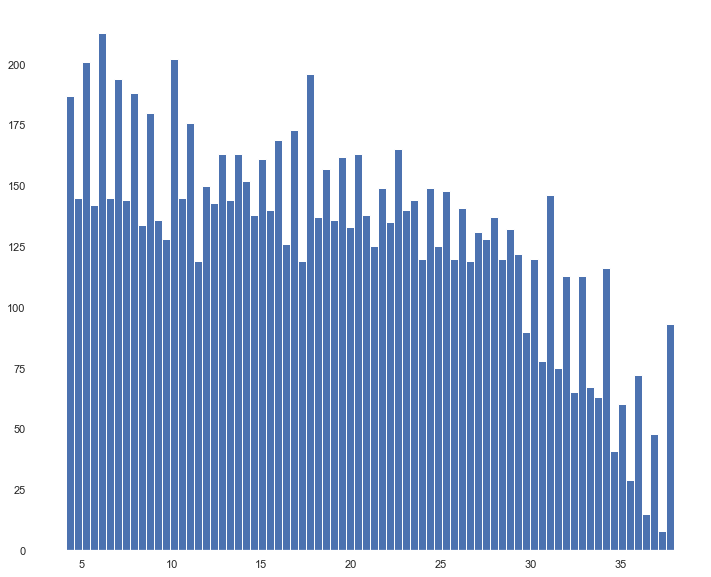

In [99]:
df["minutes_90s"].hist(bins=76)
df = df[df['minutes_90s'] > 4]

### Finding players with alot of missing data

In [132]:
for player in df["player"].unique():
    # Checking if the non-goalkeeper 
    empty_test = np.sum(df[df["player"] == 'Aaron Connolly'][non_gk_feat].sum() == 0)
    if empty_test == 15:
        print("\n Checking player", player, " : ", empty_test)
        print(df[df["player"] == player]["position"])
        print()
    break


 Checking player Aaron Connolly  :  15
0    FW
1    FW
Name: position, dtype: object

 Checking player Aaron Cresswell  :  15
3    DF
4    DF
5    DF
6    DF
7    DF
Name: position, dtype: object

 Checking player Aaron Hickey  :  15
8    DF
9    DF
Name: position, dtype: object

 Checking player Aaron Hunt  :  15
10    MF,FW
Name: position, dtype: object

 Checking player Aaron Lennon  :  15
11    FW,MF
12       MF
13       MF
14       MF
Name: position, dtype: object

 Checking player Aaron Leya Iseka  :  15
15    FW
16    FW
17    FW
Name: position, dtype: object

 Checking player Aaron Mooy  :  15
18       MF
19    MF,FW
20    MF,FW
Name: position, dtype: object

 Checking player Aaron Ramsdale  :  15
21    GK
22    GK
23    GK
Name: position, dtype: object

 Checking player Aaron Ramsey  :  15
24    MF
25    MF
26    MF
27    MF
Name: position, dtype: object

 Checking player Aaron Wan-Bissaka  :  15
30    DF
31    DF
32    DF
33    DF
34    DF
Name: position, dtype: object

 Che

318       MF
319       MF
320       MF
321    MF,DF
322       MF
Name: position, dtype: object

 Checking player Alberto Moreno  :  15
324       DF
326       DF
328    MF,DF
Name: position, dtype: object

 Checking player Alberto Paloschi  :  15
330    FW
331    FW
Name: position, dtype: object

 Checking player Alberto Perea  :  15
333    MF
334    MF
Name: position, dtype: object

 Checking player Alberto Soro  :  15
336    FW,MF
337    MF,FW
Name: position, dtype: object

 Checking player Alberto de la Bella  :  15
338    DF
Name: position, dtype: object

 Checking player Albin Ekdal  :  15
340    MF
341    MF
342    MF
343    MF
344    MF
Name: position, dtype: object

 Checking player Aleandro Rosi  :  15
345    DF,MF
Name: position, dtype: object

 Checking player Aleix Febas  :  15
346    MF
Name: position, dtype: object

 Checking player Aleix García  :  15
348    MF
349    MF
350    MF
Name: position, dtype: object

 Checking player Aleix Vidal  :  15
351    MF,FW
352    DF,MF

Name: position, dtype: object

 Checking player Amir Rrahmani  :  15
697    DF
698    DF
699    DF
Name: position, dtype: object

 Checking player Amos Pieper  :  15
700    DF
701    DF
Name: position, dtype: object

 Checking player Anaitz Arbilla  :  15
702    DF
703    DF
704    DF
705    DF
Name: position, dtype: object

 Checking player Anastasios Donis  :  15
707    FW,MF
708    FW,MF
709    FW,MF
711    FW,MF
Name: position, dtype: object

 Checking player Ander Barrenetxea  :  15
712    FW,MF
713    FW,MF
714    MF,FW
715    FW,MF
Name: position, dtype: object

 Checking player Ander Capa  :  15
716    DF
717    DF
718    DF
719    DF
Name: position, dtype: object

 Checking player Ander Guevara  :  15
721    MF
722    MF
723    MF
Name: position, dtype: object

 Checking player Ander Herrera  :  15
724       MF
725       MF
726    MF,DF
727       MF
728       MF
Name: position, dtype: object

 Checking player Ander Iturraspe  :  15
729    MF
Name: position, dtype: object

 Che

 Checking player Anthony Lopes  :  15
1008    GK
1009    GK
1010    GK
1011    GK
1012    GK
Name: position, dtype: object

 Checking player Anthony Losilla  :  15
1013    MF
Name: position, dtype: object

 Checking player Anthony Lozano  :  15
1014    FW,MF
1015    FW,MF
1016    FW,MF
1017    FW,MF
Name: position, dtype: object

 Checking player Anthony Mandrea  :  15
1018    GK
Name: position, dtype: object

 Checking player Anthony Martial  :  15
1019       FW
1020       FW
1021       FW
1022       FW
1023    FW,MF
Name: position, dtype: object

 Checking player Anthony Modeste  :  15
1024    FW,MF
1026       FW
Name: position, dtype: object

 Checking player Anthony Racioppi  :  15
1027    GK
Name: position, dtype: object

 Checking player Anthony Ujah  :  15
1029    FW,MF
1030    FW,MF
Name: position, dtype: object

 Checking player Antoine Griezmann  :  15
1036       FW
1037       FW
1038       FW
1039    FW,MF
Name: position, dtype: object

 Checking player Anton Stach  :  15
10

Name: position, dtype: object

 Checking player Baissama Sankoh  :  15
1330    MF,DF
1331    MF,FW
Name: position, dtype: object

 Checking player Bakary Koné  :  15
1332    DF
Name: position, dtype: object

 Checking player Bakary Sako  :  15
1333    FW,MF
Name: position, dtype: object

 Checking player Bakaye Dibassy  :  15
1336    DF
1337    DF
1338    DF
Name: position, dtype: object

 Checking player Bamba Dieng  :  15
1342    FW,MF
Name: position, dtype: object

 Checking player Banzouzi Locko  :  15
1345    MF,DF
Name: position, dtype: object

 Checking player Baptiste Guillaume  :  15
1347    FW
1348    FW
Name: position, dtype: object

 Checking player Baptiste Reynet  :  15
1350    GK
1351    GK
1352    GK
1353    GK
Name: position, dtype: object

 Checking player Baptiste Santamaria  :  15
1354    MF
1355    MF
1356    MF
1357    MF
Name: position, dtype: object

 Checking player Bartosz Bereszyński  :  15
1362    DF
1363    DF
1364    DF
1365    DF
1366    DF
Name: position

Name: position, dtype: object

 Checking player Bram Nuytinck  :  15
1664    DF
1665    DF
1666    DF
1667    DF
1668    DF
Name: position, dtype: object

 Checking player Brandon  :  15
1670    FW
Name: position, dtype: object

 Checking player Brandon Soppy  :  15
1674       DF
1675    DF,MF
Name: position, dtype: object

 Checking player Brandon Williams  :  15
1676    DF
1678    DF
Name: position, dtype: object

 Checking player Branimir Hrgota  :  15
1681    FW
Name: position, dtype: object

 Checking player Branislav Ivanović  :  15
1682    DF
Name: position, dtype: object

 Checking player Breel Embolo  :  15
1685    FW,MF
1686       FW
1687    FW,MF
1688    FW,MF
1689    FW,MF
Name: position, dtype: object

 Checking player Brendan Chardonnet  :  15
1690    DF
1691    DF
1692    DF
Name: position, dtype: object

 Checking player Brian Oliván  :  15
1696    DF
Name: position, dtype: object

 Checking player Brice Samba  :  15
1698    GK
Name: position, dtype: object

 Checking p


 Checking player Cheikh N'Doye  :  15
1972    MF
Name: position, dtype: object

 Checking player Cheikhou Kouyaté  :  15
1977       MF
1978       MF
1979    MF,DF
1980       DF
1981       MF
Name: position, dtype: object

 Checking player Chema  :  15
1983       DF
1984       DF
1986    DF,MF
Name: position, dtype: object

 Checking player Chidozie Awaziem  :  15
1988    DF
1989    DF
Name: position, dtype: object

 Checking player Chimuanya Ugochukwu  :  15
1992    MF
Name: position, dtype: object

 Checking player Chory Castro  :  15
1994    MF,FW
Name: position, dtype: object

 Checking player Chris Basham  :  15
1995       DF
1996    DF,MF
Name: position, dtype: object

 Checking player Chris Brunt  :  15
1997    MF,DF
Name: position, dtype: object

 Checking player Chris Führich  :  15
1999    MF,FW
Name: position, dtype: object

 Checking player Chris Löwe  :  15
2000       DF
2001    DF,FW
Name: position, dtype: object

 Checking player Chris Mepham  :  15
2002    DF
2003    DF


 Checking player Cyrus Christie  :  15
2298    DF
Name: position, dtype: object

 Checking player Cárdenas  :  15
2299    GK
2300    GK
Name: position, dtype: object

 Checking player Cédric Bakambu  :  15
2301    FW
Name: position, dtype: object

 Checking player Cédric Brunner  :  15
2303    DF
2304    DF
Name: position, dtype: object

 Checking player Cédric Hountondji  :  15
2305    DF
Name: position, dtype: object

 Checking player Cédric Soares  :  15
2306    DF
2307    DF
2309    DF
2310    DF
Name: position, dtype: object

 Checking player Cédric Varrault  :  15
2311    DF
Name: position, dtype: object

 Checking player Cédric Yamberé  :  15
2312    DF
2313    DF
Name: position, dtype: object

 Checking player César Azpilicueta  :  15
2314    DF
2315    DF
2316    DF
2317    DF
2318    DF
Name: position, dtype: object

 Checking player Daam Foulon  :  15
2319    DF
Name: position, dtype: object

 Checking player Daan Dierckx  :  15
2320    DF
Name: position, dtype: object

 Ch


 Checking player Darío Poveda  :  15
2618    FW,MF
Name: position, dtype: object

 Checking player David Abraham  :  15
2619    DF
2620    DF
2621    DF
2622    DF
Name: position, dtype: object

 Checking player David Alaba  :  15
2623       DF
2624       DF
2625       DF
2626    DF,MF
2627       DF
Name: position, dtype: object

 Checking player David Brooks  :  15
2630    MF
2631    MF
Name: position, dtype: object

 Checking player David Costas  :  15
2634    DF
Name: position, dtype: object

 Checking player David Ferreiro  :  15
2636    FW,MF
2637    MF,FW
Name: position, dtype: object

 Checking player David García  :  15
2638    DF
2639    DF
2640    DF
2641    DF
Name: position, dtype: object

 Checking player David Juncà  :  15
2643    DF
2644    DF
Name: position, dtype: object

 Checking player David Lombán  :  15
2646    DF
Name: position, dtype: object

 Checking player David Luiz  :  15
2647    DF,MF
2648       DF
2649       DF
2650       DF
Name: position, dtype: object

2961    DF,MF
2963       DF
2964       DF
Name: position, dtype: object

 Checking player Diogo Jota  :  15
2965    FW,MF
2966    FW,MF
2967       FW
2968       FW
Name: position, dtype: object

 Checking player Dion Lopy  :  15
2970    MF
Name: position, dtype: object

 Checking player Divock Origi  :  15
2974    FW
2975    FW
2976    FW
Name: position, dtype: object

 Checking player Djené  :  15
2982    DF
2983    DF
2984    DF
2985    DF
2986    DF
Name: position, dtype: object

 Checking player Djibril Sidibé  :  15
2987       DF
2988    DF,MF
2989       DF
2990       DF
2991       DF
Name: position, dtype: object

 Checking player Djibril Sow  :  15
2992    MF
2993    MF
2994    MF
Name: position, dtype: object

 Checking player Dodi Lukebakio  :  15
2997    FW,MF
2998    FW,MF
2999    FW,MF
Name: position, dtype: object

 Checking player Domagoj Bradarić  :  15
3001    DF
3002    DF
Name: position, dtype: object

 Checking player Domen Črnigoj  :  15
3004    MF,DF
Name: position

Name: position, dtype: object

 Checking player Emmanuel Bourgaud  :  15
3318    MF,FW
Name: position, dtype: object

 Checking player Emmanuel Dennis  :  15
3319       FW
3320    FW,MF
Name: position, dtype: object

 Checking player Emmanuel Gyasi  :  15
3321       FW
3322    FW,DF
Name: position, dtype: object

 Checking player Emmanuel Imorou  :  15
3324    DF
Name: position, dtype: object

 Checking player Emmanuel Rivière  :  15
3325       FW
3326    FW,MF
Name: position, dtype: object

 Checking player Emre Can  :  15
3327       MF
3328       MF
3329    MF,DF
3330    DF,MF
3331    DF,MF
Name: position, dtype: object

 Checking player Emre Mor  :  15
3332    FW,MF
3333    FW,MF
3334    FW,MF
Name: position, dtype: object

 Checking player Emre Çolak  :  15
3335    MF,FW
Name: position, dtype: object

 Checking player Enda Stevens  :  15
3337    DF
3338    DF
Name: position, dtype: object

 Checking player Eneko Bóveda  :  15
3339    DF
Name: position, dtype: object

 Checking play

 Checking player Fali Candé  :  15
3603    DF
Name: position, dtype: object

 Checking player Fallou Diagne  :  15
3604    DF,MF
Name: position, dtype: object

 Checking player Faouzi Ghoulam  :  15
3605    DF
3606    DF
3607    DF
Name: position, dtype: object

 Checking player Farid Boulaya  :  15
3611       FW
3612    MF,FW
3613    MF,FW
Name: position, dtype: object

 Checking player Farid El Melali  :  15
3616    FW,MF
Name: position, dtype: object

 Checking player Fayçal Fajr  :  15
3620    MF,FW
3621       MF
3622       MF
Name: position, dtype: object

 Checking player Fede San Emeterio  :  15
3623    MF
3624    MF
3625    MF
Name: position, dtype: object

 Checking player Fede Vico  :  15
3626    MF,FW
3627    MF,FW
Name: position, dtype: object

 Checking player Federico Barba  :  15
3628    DF
3629    DF
3630    DF
Name: position, dtype: object

 Checking player Federico Bernardeschi  :  15
3631    FW,MF
3632    FW,MF
3633    MF,FW
3634    DF,MF
3635    MF,FW
Name: position

Name: position, dtype: object

 Checking player Francesco Acerbi  :  15
3929    DF
3930    DF
3931    DF
3932    DF
3933    DF
Name: position, dtype: object

 Checking player Francesco Caputo  :  15
3936    FW
3937    FW
3938    FW
3939    FW
Name: position, dtype: object

 Checking player Francesco Cassata  :  15
3940       MF
3941    MF,FW
3942       MF
Name: position, dtype: object

 Checking player Francesco Di Tacchio  :  15
3946    MF
Name: position, dtype: object

 Checking player Francesco Forte  :  15
3947    FW
Name: position, dtype: object

 Checking player Francesco Magnanelli  :  15
3948    MF
3949    MF
3950    MF
3951    MF
Name: position, dtype: object

 Checking player Francesco Vicari  :  15
3959    DF
3960    DF
3961    DF
Name: position, dtype: object

 Checking player Francesco Zampano  :  15
3962    DF,MF
3963    DF,MF
Name: position, dtype: object

 Checking player Francis Coquelin  :  15
3964    MF,DF
3965       MF
3966       MF
3967       MF
3968       MF
Name:


 Checking player Gerard Gumbau  :  15
4226    MF
4227    MF
4228    MF
Name: position, dtype: object

 Checking player Gerard Moreno  :  15
4229       FW
4230       FW
4231    FW,MF
4232    FW,MF
4233       FW
Name: position, dtype: object

 Checking player Gerard Piqué  :  15
4234    DF
4235    DF
4236    DF
4237    DF
4238    DF
Name: position, dtype: object

 Checking player Germán Pezzella  :  15
4241    DF
4242    DF
4243    DF
4244    DF
4245    DF
Name: position, dtype: object

 Checking player Germán Sánchez  :  15
4246    DF
4247    DF
4248    DF
Name: position, dtype: object

 Checking player Gerrit Holtmann  :  15
4251    DF,FW
4253    MF,DF
4254    FW,MF
Name: position, dtype: object

 Checking player Gerson  :  15
4255    MF,FW
4256    MF,FW
4257    MF,FW
Name: position, dtype: object

 Checking player Gerson Rodrigues  :  15
4258    FW
Name: position, dtype: object

 Checking player Gervinho  :  15
4259    FW
4260    FW
4261    FW
Name: position, dtype: object

 Checking


 Checking player Hamari Traoré  :  15
4565    DF
4566    DF
4567    DF
4568    DF
4569    DF
Name: position, dtype: object

 Checking player Hamed Junior Traorè  :  15
4570       MF
4571    MF,FW
4572    FW,MF
4573    FW,MF
Name: position, dtype: object

 Checking player Hamza Choudhury  :  15
4574    MF,DF
4575       MF
4576       MF
Name: position, dtype: object

 Checking player Hamza Mendyl  :  15
4579    DF,MF
4580    DF,MF
4581       DF
Name: position, dtype: object

 Checking player Hannes Wolf  :  15
4586    MF,FW
Name: position, dtype: object

 Checking player Hanno Behrens  :  15
4590    MF
Name: position, dtype: object

 Checking player Hans Hateboer  :  15
4591    DF,MF
4592    DF,MF
4593       DF
4594       DF
4595       DF
Name: position, dtype: object

 Checking player Hans Nunoo Sarpei  :  15
4598    DF,MF
Name: position, dtype: object

 Checking player Haris Belkebla  :  15
4599    MF
4600    MF
4601    MF
Name: position, dtype: object

 Checking player Haris Duljević

4900       DF
4901    DF,MF
Name: position, dtype: object

 Checking player Isaac Cofie  :  15
4902    MF
Name: position, dtype: object

 Checking player Isaac Hayden  :  15
4903       MF
4904       MF
4905       MF
4906    MF,DF
4907    MF,DF
Name: position, dtype: object

 Checking player Isaac Mbenza  :  15
4913    FW,MF
4914    FW,MF
Name: position, dtype: object

 Checking player Isaac Palazón Camacho  :  15
4916    FW,MF
Name: position, dtype: object

 Checking player Isaac Success  :  15
4917    MF,FW
4918    FW,MF
4920       FW
Name: position, dtype: object

 Checking player Isco  :  15
4921       MF
4922    MF,FW
4923    FW,MF
4924    MF,FW
Name: position, dtype: object

 Checking player Ishak Belfodil  :  15
4926    FW
4927    FW
4929    FW
4930    FW
Name: position, dtype: object

 Checking player Islam Slimani  :  15
4932    FW
4933    FW
4934    FW
Name: position, dtype: object

 Checking player Ismail Jakobs  :  15
4940    FW,DF
4941    DF,MF
4942       DF
Name: position,

5220    FW
5221    FW
5222    FW
5223    FW
5224    FW
Name: position, dtype: object

 Checking player Jamilu Collins  :  15
5225    DF
Name: position, dtype: object

 Checking player Jan Bednarek  :  15
5226    DF
5227    DF
5228    DF
5229    DF
5230    DF
Name: position, dtype: object

 Checking player Jan Morávek  :  15
5233    MF
5234    MF
5235    MF
5237    MF
Name: position, dtype: object

 Checking player Jan Oblak  :  15
5238    GK
5239    GK
5240    GK
5241    GK
5242    GK
Name: position, dtype: object

 Checking player Jan Repas  :  15
5243    MF,FW
Name: position, dtype: object

 Checking player Jan Thielmann  :  15
5244    FW,MF
5245    FW,MF
5246    MF,FW
Name: position, dtype: object

 Checking player Jan Vertonghen  :  15
5247    DF
5248    DF
5249    DF
Name: position, dtype: object

 Checking player Janik Haberer  :  15
5252    MF,FW
5253    MF,FW
5254    MF,FW
5255    MF,FW
5256       MF
Name: position, dtype: object

 Checking player Janis Antiste  :  15
5258    F

 Checking player Jessy Moulin  :  15
5555    GK
5556    GK
Name: position, dtype: object

 Checking player Jesus Vazquez  :  15
5559    DF,MF
Name: position, dtype: object

 Checking player Jesé  :  15
5560    FW,MF
5561    FW,MF
Name: position, dtype: object

 Checking player Jesús Corona  :  15
5565    FW,DF
Name: position, dtype: object

 Checking player Jesús Navas  :  15
5567    DF,FW
5568    DF,MF
5569       DF
5570       DF
5571       DF
Name: position, dtype: object

 Checking player Jesús Vallejo  :  15
5574    DF
5576    DF
5577    DF
Name: position, dtype: object

 Checking player Jetro Willems  :  15
5579    DF,MF
5580    MF,DF
5581       DF
5582       DF
Name: position, dtype: object

 Checking player Jhon Chancellor  :  15
5583    DF
Name: position, dtype: object

 Checking player Jhon Córdoba  :  15
5584    FW
5585    FW
5586    FW
Name: position, dtype: object

 Checking player Jhonder Cádiz  :  15
5587    FW,MF
Name: position, dtype: object

 Checking player Ji Dong-wo


 Checking player Jonás Ramalho  :  15
5866    DF
5867    DF
Name: position, dtype: object

 Checking player Jordan Amavi  :  15
5870    DF
5871    DF
5872    DF
5873    DF
Name: position, dtype: object

 Checking player Jordan Ayew  :  15
5875    FW,MF
5876       FW
5877    FW,MF
5878    FW,MF
5879       FW
Name: position, dtype: object

 Checking player Jordan Ferri  :  15
5880    MF
5881    MF
5882    MF
5883    MF
5884    MF
Name: position, dtype: object

 Checking player Jordan Henderson  :  15
5885       MF
5886       MF
5887       MF
5888    MF,DF
5889       MF
Name: position, dtype: object

 Checking player Jordan Ikoko  :  15
5892    DF
5893    DF
Name: position, dtype: object

 Checking player Jordan Lefort  :  15
5894    DF,MF
5895       DF
Name: position, dtype: object

 Checking player Jordan Lotomba  :  15
5896    DF
5897    DF
Name: position, dtype: object

 Checking player Jordan Lukaku  :  15
5898    DF,MF
5900       DF
Name: position, dtype: object

 Checking player J

 Checking player Juanmi  :  15
6221    FW,MF
6222    FW,MF
6224    FW,MF
6225       FW
Name: position, dtype: object

 Checking player Juanpe  :  15
6226    DF
6227    DF
Name: position, dtype: object

 Checking player Juanpi  :  15
6228    MF,FW
6229    MF,FW
Name: position, dtype: object

 Checking player Jude Bellingham  :  15
6230    MF
6231    MF
Name: position, dtype: object

 Checking player Jules Iloki  :  15
6234    MF,FW
Name: position, dtype: object

 Checking player Jules Keita  :  15
6235    FW,MF
Name: position, dtype: object

 Checking player Jules Koundé  :  15
6237    DF
6238    DF
6239    DF
6240    DF
6241    DF
Name: position, dtype: object

 Checking player Julian Baumgartlinger  :  15
6242    MF,DF
6243       MF
6244       MF
6245       MF
Name: position, dtype: object

 Checking player Julian Brandt  :  15
6247    FW,MF
6248    MF,FW
6249    MF,FW
6250    FW,MF
6251    MF,FW
Name: position, dtype: object

 Checking player Julian Chabot  :  15
6252    DF
6253    D


 Checking player Kenneth Zohore  :  15
6539    FW
Name: position, dtype: object

 Checking player Kenny Lala  :  15
6540       DF
6541    DF,MF
6542       DF
6543       DF
Name: position, dtype: object

 Checking player Kenny McLean  :  15
6544    MF
6545    MF
Name: position, dtype: object

 Checking player Kenny Tete  :  15
6548    DF
6549    DF
6550    DF
Name: position, dtype: object

 Checking player Kepa Arrizabalaga  :  15
6552    GK
6553    GK
6554    GK
6555    GK
Name: position, dtype: object

 Checking player Kerem Demirbay  :  15
6557    MF
6558    MF
6559    MF
6560    MF
6561    MF
Name: position, dtype: object

 Checking player Keven Schlotterbeck  :  15
6563    DF
6564    DF
6565    DF
Name: position, dtype: object

 Checking player Kevin Agudelo  :  15
6568       FW
6569    FW,MF
Name: position, dtype: object

 Checking player Kevin Akpoguma  :  15
6570    DF
6572    DF
6573    DF
6574    DF
Name: position, dtype: object

 Checking player Kevin Behrens  :  15
6575    


 Checking player Lamine Koné  :  15
6888    DF
6889    DF
6890    DF
Name: position, dtype: object

 Checking player Lamine Sané  :  15
6891    DF
Name: position, dtype: object

 Checking player Landry Dimata  :  15
6893    FW,MF
6894    FW,MF
Name: position, dtype: object

 Checking player Lars Bender  :  15
6896    DF,MF
6897    DF,MF
6898    DF,MF
6899       DF
Name: position, dtype: object

 Checking player Lars Stindl  :  15
6901    FW,MF
6902    FW,MF
6903    MF,FW
6904    MF,FW
6905    MF,FW
Name: position, dtype: object

 Checking player Lassana Coulibaly  :  15
6906       MF
6907    MF,FW
6908       MF
Name: position, dtype: object

 Checking player Lassana Diarra  :  15
6909    MF
Name: position, dtype: object

 Checking player Lasse Schöne  :  15
6912    MF
Name: position, dtype: object

 Checking player Laurent Abergel  :  15
6916    MF
6917    MF
Name: position, dtype: object

 Checking player Laurent Ciman  :  15
6918    DF
Name: position, dtype: object

 Checking player

 Checking player Luca Cigarini  :  15
7221    MF
7222    MF
7223    MF
7224    MF
Name: position, dtype: object

 Checking player Luca Fiordilino  :  15
7227    MF
Name: position, dtype: object

 Checking player Luca Kilian  :  15
7233    DF
7234    DF
Name: position, dtype: object

 Checking player Luca Lezzerini  :  15
7236    GK
Name: position, dtype: object

 Checking player Luca Marrone  :  15
7238    DF
Name: position, dtype: object

 Checking player Luca Mazzitelli  :  15
7240    MF
Name: position, dtype: object

 Checking player Luca Mora  :  15
7243    MF
Name: position, dtype: object

 Checking player Luca Netz  :  15
7246    DF
Name: position, dtype: object

 Checking player Luca Paganini  :  15
7247    DF,MF
Name: position, dtype: object

 Checking player Luca Pellegrini  :  15
7249       DF
7250    DF,MF
7251       DF
Name: position, dtype: object

 Checking player Luca Ranieri  :  15
7254    DF
Name: position, dtype: object

 Checking player Luca Rigoni  :  15
7255    MF,

 Checking player Léo Lacroix  :  15
7562    DF
Name: position, dtype: object

 Checking player Léo Leroy  :  15
7563    MF
Name: position, dtype: object

 Checking player Léo Pétrot  :  15
7564    DF
Name: position, dtype: object

 Checking player Léo Sena  :  15
7565    MF
Name: position, dtype: object

 Checking player M'Bala Nzola  :  15
7566    FW
7567    FW
Name: position, dtype: object

 Checking player M'Baye Niang  :  15
7568    FW
7569    FW
7570    FW
7571    FW
7572    FW
Name: position, dtype: object

 Checking player Mads Bech Sørensen  :  15
7573    DF
Name: position, dtype: object

 Checking player Mads Pedersen  :  15
7576       DF
7577    DF,MF
Name: position, dtype: object

 Checking player Mads Roerslev  :  15
7578    DF
Name: position, dtype: object

 Checking player Mahdi Camara  :  15
7585       MF
7586    MF,DF
7587    MF,DF
Name: position, dtype: object

 Checking player Mahmoud Dahoud  :  15
7589    MF
7590    MF
7591    MF
7592    MF
7593    MF
Name: position,

7865    FW,MF
7867    MF,FW
Name: position, dtype: object

 Checking player Marco Silvestri  :  15
7869    GK
7870    GK
7871    GK
Name: position, dtype: object

 Checking player Marco Sportiello  :  15
7872    GK
7873    GK
7874    GK
7875    GK
7876    GK
Name: position, dtype: object

 Checking player Marco Stiepermann  :  15
7877    MF
Name: position, dtype: object

 Checking player Marco Terrazzino  :  15
7878    MF,FW
7879    FW,MF
Name: position, dtype: object

 Checking player Marco Verratti  :  15
7882    MF
7883    MF
7884    MF
7885    MF
7886    MF
Name: position, dtype: object

 Checking player Marcos Acuña  :  15
7887    DF
7888    DF
Name: position, dtype: object

 Checking player Marcos Alonso  :  15
7889    DF
7890    DF
7891    DF
7892    DF
7893    DF
Name: position, dtype: object

 Checking player Marcos Llorente  :  15
7894       MF
7895       MF
7896    MF,FW
7897    MF,DF
7898    DF,MF
Name: position, dtype: object

 Checking player Marcos Mauro López Gutiérrez 

 Checking player Mateo Pavlović  :  15
8198    DF
8199    DF
8200    DF
8201    DF
Name: position, dtype: object

 Checking player Mateu Morey  :  15
8203    DF
Name: position, dtype: object

 Checking player Mateusz Klich  :  15
8204    MF
8205    MF
Name: position, dtype: object

 Checking player Matheus Cunha  :  15
8207    FW,MF
8208    FW,MF
8209    FW,MF
Name: position, dtype: object

 Checking player Matheus Henrique  :  15
8212    MF
Name: position, dtype: object

 Checking player Matheus Pereira  :  15
8213    MF,FW
8214    MF,FW
Name: position, dtype: object

 Checking player Matheus Pereira da Silva  :  15
8216    MF,FW
Name: position, dtype: object

 Checking player Mathew Leckie  :  15
8217    FW,MF
8218    FW,MF
8220    FW,DF
Name: position, dtype: object

 Checking player Mathew Ryan  :  15
8221    GK
8222    GK
8223    GK
8224    GK
Name: position, dtype: object

 Checking player Mathias Autret  :  15
8226    MF,FW
Name: position, dtype: object

 Checking player Mathias

 Checking player Maxime Le Marchand  :  15
8505    DF
8506    DF
8508    DF
Name: position, dtype: object

 Checking player Maxime Lestienne  :  15
8509    MF,FW
Name: position, dtype: object

 Checking player Maxime Lopez  :  15
8510       MF
8511       MF
8512    MF,FW
8514       MF
Name: position, dtype: object

 Checking player Maxime Poundjé  :  15
8515    DF
8516    DF
8518    DF
Name: position, dtype: object

 Checking player Maximilian Arnold  :  15
8520    MF
8521    MF
8522    MF
8523    MF
8524    MF
Name: position, dtype: object

 Checking player Maximilian Bauer  :  15
8525    DF
Name: position, dtype: object

 Checking player Maximilian Eggestein  :  15
8528       MF
8529       MF
8530    MF,DF
8531       MF
8532       MF
Name: position, dtype: object

 Checking player Maximilian Mittelstädt  :  15
8533    MF,DF
8534    DF,MF
8535    DF,FW
8536       DF
8537    DF,FW
Name: position, dtype: object

 Checking player Maximilian Philipp  :  15
8538    FW,MF
8539    FW,MF
8540

8828    FW
Name: position, dtype: object

 Checking player Mohamed Bayo  :  15
8829    FW
Name: position, dtype: object

 Checking player Mohamed Diamé  :  15
8830    MF
8831    MF
Name: position, dtype: object

 Checking player Mohamed Dräger  :  15
8833    DF
Name: position, dtype: object

 Checking player Mohamed Elneny  :  15
8834    MF
8835    MF
8836    MF
Name: position, dtype: object

 Checking player Mohamed Elyounoussi  :  15
8838    MF,FW
8839    MF,FW
Name: position, dtype: object

 Checking player Mohamed Fares  :  15
8840    DF,MF
8841    DF,MF
8842    DF,MF
8843       DF
8844    DF,FW
Name: position, dtype: object

 Checking player Mohamed Salah  :  15
8847    FW
8848    FW
8849    FW
8850    FW
8851    FW
Name: position, dtype: object

 Checking player Mohamed Simakan  :  15
8854    DF
8855    DF
8856    DF
Name: position, dtype: object

 Checking player Mohammed Salisu  :  15
8857    DF
8858    DF
8859    DF
Name: position, dtype: object

 Checking player Moi Gómez  : 

9148    MF,FW
9149       MF
9150       MF
9151       MF
9152       MF
Name: position, dtype: object

 Checking player Nemanja Matić  :  15
9153    MF
9154    MF
9155    MF
9156    MF
9157    MF
Name: position, dtype: object

 Checking player Nemanja Radoja  :  15
9158    MF
9159    MF
9160    MF
9161    MF
Name: position, dtype: object

 Checking player Nemanja Radonjić  :  15
9162       FW
9163    FW,MF
9164    FW,DF
Name: position, dtype: object

 Checking player Nenad Tomović  :  15
9167    DF
9168    DF
Name: position, dtype: object

 Checking player Neto  :  15
9170    GK
9171    GK
9173    GK
Name: position, dtype: object

 Checking player Neven Subotić  :  15
9176    DF
9177    DF
Name: position, dtype: object

 Checking player Neymar  :  15
9178    FW,MF
9179    MF,FW
9180    MF,FW
9181    MF,FW
9182    FW,MF
Name: position, dtype: object

 Checking player Nianzou Kouassi  :  15
9184    DF,MF
9186    DF,MF
Name: position, dtype: object

 Checking player Niccolò Zanellato  :  15


 Checking player Oliver Fink  :  15
9495       MF
9496    MF,FW
Name: position, dtype: object

 Checking player Oliver McBurnie  :  15
9499    FW
9500    FW
Name: position, dtype: object

 Checking player Oliver Norwood  :  15
9501    MF
9502    MF
Name: position, dtype: object

 Checking player Oliver Skipp  :  15
9505    MF
Name: position, dtype: object

 Checking player Oliver Sorg  :  15
9506    DF
9507    DF
Name: position, dtype: object

 Checking player Olivier Boscagli  :  15
9508    DF,MF
Name: position, dtype: object

 Checking player Olivier Giroud  :  15
9509    FW
9510    FW
9511    FW
9512    FW
9513    FW
Name: position, dtype: object

 Checking player Ollie Watkins  :  15
9516    FW
9517    FW
Name: position, dtype: object

 Checking player Omar Alderete  :  15
9518    DF
9519    DF
Name: position, dtype: object

 Checking player Omar Colley  :  15
9520    DF
9521    DF
9522    DF
9523    DF
Name: position, dtype: object

 Checking player Omar Mascarell  :  15
9528    


 Checking player Paulinho  :  15
9812       MF
9816    FW,MF
Name: position, dtype: object

 Checking player Paulo Dybala  :  15
9818    MF,FW
9819    FW,MF
9820    FW,MF
9821       FW
9822    FW,MF
Name: position, dtype: object

 Checking player Paulo Gazzaniga  :  15
9825    GK
9826    GK
Name: position, dtype: object

 Checking player Paulo Oliveira  :  15
9827    DF
9828    DF
9829    DF
9830    DF
Name: position, dtype: object

 Checking player Paulo Otávio  :  15
9831    DF
9832    DF
Name: position, dtype: object

 Checking player Pavao Pervan  :  15
9834    GK
9835    GK
9837    GK
Name: position, dtype: object

 Checking player Pavel Kadeřábek  :  15
9838    DF,MF
9839    DF,MF
9840    DF,MF
9841       DF
9842       DF
Name: position, dtype: object

 Checking player Paweł Dawidowicz  :  15
9843    DF,MF
9844       DF
9845       DF
Name: position, dtype: object

 Checking player Paweł Jaroszyński  :  15
9846    DF,MF
9847    DF,MF
9848       DF
Name: position, dtype: object

 


 Checking player Rachid Ghezzal  :  15
10118    FW,MF
10119    FW,MF
10120    MF,FW
Name: position, dtype: object

 Checking player Racine Coly  :  15
10121       DF
10122    DF,MF
10123    DF,FW
Name: position, dtype: object

 Checking player Radamel Falcao  :  15
10125    FW
10126    FW
10127    FW
Name: position, dtype: object

 Checking player Rade Krunić  :  15
10128       MF
10129    MF,FW
10130    MF,FW
10131    MF,FW
Name: position, dtype: object

 Checking player Radja Nainggolan  :  15
10132       MF
10133       MF
10134    MF,FW
10135       MF
Name: position, dtype: object

 Checking player Radu Drăgușin  :  15
10138    DF
Name: position, dtype: object

 Checking player Rafa Mir  :  15
10139    FW
10140    FW
Name: position, dtype: object

 Checking player Rafa Soares  :  15
10142    DF
10143    DF
Name: position, dtype: object

 Checking player Rafael  :  15
10144    DF
10145    DF
10146    DF
Name: position, dtype: object

 Checking player Rafael Borré  :  15
10148    FW


 Checking player Robert Andrich  :  15
10462    MF
10463    MF
10464    MF
Name: position, dtype: object

 Checking player Robert Bauer  :  15
10465    DF
10466    DF
Name: position, dtype: object

 Checking player Robert Berić  :  15
10467       FW
10468       FW
10469    FW,MF
Name: position, dtype: object

 Checking player Robert Gumny  :  15
10471    DF
10472    DF
Name: position, dtype: object

 Checking player Robert Ibáñez  :  15
10474    MF,FW
Name: position, dtype: object

 Checking player Robert Lewandowski  :  15
10476    FW
10477    FW
10478    FW
10479    FW
10480    FW
Name: position, dtype: object

 Checking player Robert Skov  :  15
10481    DF,FW
10482    FW,DF
Name: position, dtype: object

 Checking player Robert Snodgrass  :  15
10484       MF
10485    MF,FW
10486    MF,FW
Name: position, dtype: object

 Checking player Robert Sánchez  :  15
10487    GK
10488    GK
Name: position, dtype: object

 Checking player Roberto  :  15
10491    GK
10492    GK
10493    GK
Nam

10818    DF
Name: position, dtype: object

 Checking player Ryan Bertrand  :  15
10820    DF
10821    DF
10822    DF
10823    DF
Name: position, dtype: object

 Checking player Ryan Fraser  :  15
10825    MF,DF
10826    MF,FW
10827    MF,FW
10828    FW,MF
10829    FW,MF
Name: position, dtype: object

 Checking player Ryan Fredericks  :  15
10830       DF
10831       DF
10832    DF,FW
Name: position, dtype: object

 Checking player Ryan Sessegnon  :  15
10835    FW,DF
10837       DF
10838       DF
Name: position, dtype: object

 Checking player Ryan Shawcross  :  15
10839    DF
Name: position, dtype: object

 Checking player Ryder Matos  :  15
10840    FW,MF
Name: position, dtype: object

 Checking player Régis Gurtner  :  15
10842    GK
10843    GK
10844    GK
Name: position, dtype: object

 Checking player Rémi Walter  :  15
10845       MF
10846    MF,FW
Name: position, dtype: object

 Checking player Rémy Cabella  :  15
10848    MF,FW
10849    MF,FW
Name: position, dtype: object

 Ch

11147    DF
Name: position, dtype: object

 Checking player Sebastian Vasiliadis  :  15
11149    MF
11150    MF
Name: position, dtype: object

 Checking player Sebastian Walukiewicz  :  15
11151    DF
11152    DF
Name: position, dtype: object

 Checking player Sebastiano Luperto  :  15
11155    DF
11156    DF
11157    DF
11158    DF
Name: position, dtype: object

 Checking player Sebastien De Maio  :  15
11159    DF
11160    DF
11161    DF
11162    DF
Name: position, dtype: object

 Checking player Sebastián Cristóforo  :  15
11165    MF,FW
11166       MF
Name: position, dtype: object

 Checking player Sehrou Guirassy  :  15
11167    FW,MF
11168       FW
11169       FW
11170       FW
11171       FW
Name: position, dtype: object

 Checking player Sejad Salihović  :  15
11172    MF
Name: position, dtype: object

 Checking player Seko Fofana  :  15
11173    MF
11174    MF
11175    MF
11176    MF
11177    MF
Name: position, dtype: object

 Checking player Sekou Mara  :  15
11180    FW
Name

 Checking player Son Heung-min  :  15
11481    FW,MF
11482    FW,MF
11483    FW,MF
11484       FW
11485    FW,MF
Name: position, dtype: object

 Checking player Soualiho Meïté  :  15
11488    MF
11489    MF
11490    MF
11491    MF
Name: position, dtype: object

 Checking player Souleyman Doumbia  :  15
11492    DF
11493    DF
11494    DF
11495    DF
Name: position, dtype: object

 Checking player Souleymane Camara  :  15
11496    FW
Name: position, dtype: object

 Checking player Stanislav Lobotka  :  15
11499    MF
11500    MF
11501    MF
11503    MF
Name: position, dtype: object

 Checking player Stanley N'Soki  :  15
11505    DF
11506    DF
11507    DF
Name: position, dtype: object

 Checking player Steeve Yago  :  15
11509    DF
Name: position, dtype: object

 Checking player Stef Peeters  :  15
11511    MF
11512    MF
Name: position, dtype: object

 Checking player Stefan Bajic  :  15
11515    GK
Name: position, dtype: object

 Checking player Stefan Bell  :  15
11516    DF
11517 


 Checking player Thibaut Courtois  :  15
11834    GK
11835    GK
11836    GK
11837    GK
11838    GK
Name: position, dtype: object

 Checking player Thierry Ambrose  :  15
11840    FW
11841    FW
Name: position, dtype: object

 Checking player Thierry Correia  :  15
11843    DF
11844    DF
Name: position, dtype: object

 Checking player Thilo Kehrer  :  15
11845    DF
11846    DF
11847    DF
11848    DF
11849    DF
Name: position, dtype: object

 Checking player Thomas Basila  :  15
11851    DF
Name: position, dtype: object

 Checking player Thomas Delaine  :  15
11853    DF
11854    DF
11855    DF
Name: position, dtype: object

 Checking player Thomas Delaney  :  15
11856    MF
11857    MF
11858    MF
11859    MF
Name: position, dtype: object

 Checking player Thomas Didillon  :  15
11861    GK
Name: position, dtype: object

 Checking player Thomas Foket  :  15
11863       DF
11864       DF
11865       DF
11866    DF,MF
Name: position, dtype: object

 Checking player Thomas Fontaine 


 Checking player Unai Bustinza  :  15
12181    DF
12182    DF
12183    DF
Name: position, dtype: object

 Checking player Unai García  :  15
12186    DF
12187    DF
12188    DF
Name: position, dtype: object

 Checking player Unai López  :  15
12190    MF
12191    MF
12192    MF
Name: position, dtype: object

 Checking player Unai Núñez  :  15
12193    DF
12194    DF
12195    DF
12196    DF
12197    DF
Name: position, dtype: object

 Checking player Unai Simón  :  15
12198    GK
12199    GK
12200    GK
12201    GK
Name: position, dtype: object

 Checking player Unai Vencedor Paris  :  15
12203    MF
12204    MF
Name: position, dtype: object

 Checking player Uroš Račić  :  15
12206    MF
12207    MF
Name: position, dtype: object

 Checking player Uwe Hünemeier  :  15
12209    DF
Name: position, dtype: object

 Checking player Vagner Gonçalves  :  15
12211    FW,MF
Name: position, dtype: object

 Checking player Vahid Selimović  :  15
12213    DF
Name: position, dtype: object

 Checking


 Checking player Weston McKennie  :  15
12506       MF
12507    MF,DF
12508    MF,DF
12509       MF
12510       MF
Name: position, dtype: object

 Checking player Wilfred Ndidi  :  15
12511       MF
12512       MF
12513       MF
12514    MF,DF
12515    MF,DF
Name: position, dtype: object

 Checking player Wilfrid Kaptoum  :  15
12516    MF
Name: position, dtype: object

 Checking player Wilfried Bony  :  15
12518    FW
Name: position, dtype: object

 Checking player Wilfried Kanga  :  15
12520    FW
Name: position, dtype: object

 Checking player Wilfried Singo  :  15
12524    DF
12525    DF
Name: position, dtype: object

 Checking player Wilfried Zaha  :  15
12526    FW,MF
12527    FW,MF
12528    MF,FW
12529       FW
12530       FW
Name: position, dtype: object

 Checking player Will Hughes  :  15
12532    MF,FW
12533    MF,FW
12534    MF,FW
12535       MF
Name: position, dtype: object

 Checking player Willem Geubbels  :  15
12541    FW,MF
Name: position, dtype: object

 Checking pl


 Checking player Yves Bissouma  :  15
12873    MF,DF
12874       MF
12875       MF
12876       MF
12877       MF
Name: position, dtype: object

 Checking player Yıldırım Mert Çetin  :  15
12882    DF
Name: position, dtype: object

 Checking player Zack Steffen  :  15
12885    GK
Name: position, dtype: object

 Checking player Zakaria Bakkali  :  15
12888    FW,MF
Name: position, dtype: object

 Checking player Zaydou Youssouf  :  15
12890    FW,MF
12891       MF
12892       MF
12893       MF
Name: position, dtype: object

 Checking player Zdravko Kuzmanović  :  15
12894    MF
Name: position, dtype: object

 Checking player Zeki Çelik  :  15
12895    DF
12896    DF
12897    DF
12898    DF
Name: position, dtype: object

 Checking player Zinedine Ferhat  :  15
12900    FW,MF
12901    FW,MF
Name: position, dtype: object

 Checking player Zinho Vanheusden  :  15
12902    DF
Name: position, dtype: object

 Checking player Zlatan Ibrahimović  :  15
12907    FW
12908    FW
12909    FW
Name: p

In [135]:
df[df["player"] == 'Aaron Connolly'][non_gk_feat].sum() == 0

through_balls               False
passes_ground               False
tackles                     False
passes_into_penalty_area    False
pressures                   False
                            ...  
sca_per90                   False
dribbles_vs                 False
touches_mid_3rd             False
blocks                      False
errors                       True
Length: 126, dtype: bool

In [136]:
df.columns[(df == 0).all()]

Index([], dtype='object')

In [139]:
player_df = df[df["player"] == 'Aaron Connolly']
player_df.columns[(player_df == 0).all()]

Index(['goals_against_gk', 'pens_allowed', 'free_kick_goals_against_gk',
       'corner_kick_goals_against_gk', 'own_goals_against_gk', 'psxg_gk',
       'psnpxg_per_shot_on_target_against', 'psxg_net_gk', 'psxg_net_per90_gk',
       'passes_completed_launched_gk', 'passes_launched_gk',
       'passes_pct_launched_gk', 'passes_gk', 'passes_throws_gk',
       'pct_passes_launched_gk', 'passes_length_avg_gk', 'goal_kicks',
       'pct_goal_kicks_launched', 'goal_kick_length_avg', 'crosses_gk',
       'crosses_stopped_gk', 'crosses_stopped_pct_gk',
       'def_actions_outside_pen_area_gk',
       'def_actions_outside_pen_area_per90_gk', 'avg_distance_def_actions_gk',
       'shots_free_kicks', 'pens_made', 'pens_att',
       'crosses_into_penalty_area', 'passes_free_kicks', 'corner_kicks',
       'corner_kicks_in', 'corner_kicks_out', 'corner_kicks_straight',
       'passes_offsides', 'sca_passes_dead', 'gca_passes_dead', 'gca_defense',
       'blocked_shots_saves', 'errors'],
      dtype